# ING case study.
## Prediction for shop sales in un undefinied country
the case study is about predicting the future sales of a number of different alcohol shops in un undefined area. Sales of the previous 5 years (from 2012 to 2017) are given weekly for 7 different drink categories. A second dataset reports which shops are present in a radius of 5 km for each single shop to take into account competition between different shops 

In [ ]:
# here I am installing a couple packages for the stastistical analysis of the time series
!pip install pystan
!pip install fbprophet # model developed by Facebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import some useful packages, later we will need more

import pandas as pd
from fbprophet import Prophet
import warnings; 
warnings.simplefilter('ignore')

preformatting the data

In [ ]:
# read the sales data 
data = pd.read_csv('gdrive/MyDrive/ING/store_sales_per_category.csv', sep=';')

In [ ]:
data.head()

,year,week,store_id,Vodka,Tequila,Whiskey,Other,Gin,Brandy,Rum
0,2012,1,0,1824.96,0.00,3645.81,5143.30,0.00,169.86,1507.50
1,2012,1,1,279.01,0.00,251.54,28.35,0.00,31.28,0.00
2,2012,1,2,441.60,0.00,1195.08,2434.44,231.12,162.96,395.76
3,2012,1,7,18432.50,406.68,24344.53,19546.09,3527.14,2113.41,7246.16
4,2012,1,8,3584.56,0.00,7175.44,5970.78,401.81,594.37,1043.21


In [ ]:
# pre formatting the data accoridng to the requirements from Prophet

data['ds'] = pd.to_datetime(data.year.astype(str), format='%Y') + \
             pd.to_timedelta(data.week.mul(7).astype(str) + ' days')
             
data.drop(['year', 'week'],  inplace=True, axis=1)

data_tot = data.copy()

drinks = ['Vodka','Tequila','Whiskey','Other','Gin','Brandy','Rum']

data_tot['y'] = data_tot[drinks].sum(axis=1) # summing all sales on the column y, again as required from Prophet

data_tot.drop(['Vodka','Tequila','Whiskey','Other','Gin','Brandy','Rum'],  inplace=True, axis=1)

data_tot # this will be the data set used in the analysis with prophet

,store_id,ds,y
0,0,2012-01-08,12291.43
1,1,2012-01-08,590.18
2,2,2012-01-08,4860.96
3,7,2012-01-08,75616.51
4,8,2012-01-08,18770.17
...,...,...,...
248350,1848,2017-11-05,560.43
248351,1850,2017-11-05,428.95
248352,1851,2017-11-05,960.01
248353,1854,2017-11-05,638.08


In [ ]:
# checking which last date we have in relation to which shop

recap = data_tot.copy()
recap['last_date'] = recap.groupby('store_id')['ds'].transform('max')
recap = recap[['store_id', 'last_date']].drop_duplicates().sort_values('store_id').reset_index(drop=True)
recap

,store_id,last_date
0,0,2017-10-29
1,1,2017-11-05
2,2,2017-10-29
3,3,2012-04-29
4,4,2016-02-26
...,...,...
1706,1876,2017-09-17
1707,1877,2016-10-14
1708,1878,2016-11-04
1709,1879,2016-12-23


In [ ]:
# checking which last date we have in relation to how many shops 

value_count_df = recap.copy()
value_count_df['count'] = value_count_df.groupby('last_date').transform('count')
value_count_df = value_count_df[['last_date', 'count']].drop_duplicates().sort_values('count', ascending=False).reset_index(drop=True)
value_count_df.head(20)

,last_date,count
0,2017-10-29,577
1,2017-11-05,447
2,2017-10-22,124
3,2017-10-15,65
4,2017-10-08,29
5,2017-09-24,12
6,2017-10-01,12
7,2017-09-17,8
8,2015-04-02,8
9,2016-02-26,7


In [ ]:
# standardization of the sales for each item

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data[drinks])
fitted_cols = scaler.transform(data[drinks])

df_fit = data[['ds', 'store_id']]
df_fit[drinks] = pd.DataFrame(fitted_cols, columns = drinks)
df_fit.head()

,ds,store_id,Vodka,Tequila,Whiskey,Other,Gin,Brandy,Rum
0,2012-01-08,0,0.410989,-0.136655,0.642042,2.256383,-0.326510,-0.058621,0.742534
1,2012-01-08,1,-0.277942,-0.136655,-0.364732,-0.301847,-0.326510,-0.335611,-0.301037
2,2012-01-08,2,-0.205486,-0.136655,-0.084869,0.901553,0.164336,-0.072413,-0.027071
3,2012-01-08,7,7.811906,1.947979,6.781484,9.459904,7.164332,3.826089,4.715139
4,2012-01-08,8,1.195130,-0.136655,1.688965,2.670245,0.526843,0.789877,0.421128


In [ ]:
# preparing the data set for the items standardized to be plotted in the next cell

avg_df = df_fit.copy()

# tot_drinks = drinks +['Total']
for drink in drinks:
  col_name = 'avg_' + drink
  avg_df[col_name] = avg_df.groupby(['ds'])[drink].transform('mean')

avg_df.head()

In [ ]:
avg_df = avg_df[['ds', 'avg_Vodka', 'avg_Tequila', 'avg_Whiskey', 'avg_Other', 'avg_Gin', 'avg_Brandy', 'avg_Rum']].drop_duplicates()
avg_df = avg_df.rename(columns={'avg_Vodka':'Vodka', 'avg_Tequila':'Tequila', 'avg_Whiskey':'Whiskey', 'avg_Other':'Other', 'avg_Gin':'Gin', 'avg_Brandy':'Brandy', 'avg_Rum':'Rum'})
avg_df.head()

,ds,Vodka,Tequila,Whiskey,Other,Gin,Brandy,Rum
0,2012-01-08,-0.010346,-0.121635,-0.003862,0.168138,-0.007788,0.003046,0.017008
613,2012-01-15,-0.083381,-0.126071,-0.136549,0.030137,-0.056268,-0.083967,-0.053037
1368,2012-01-22,-0.001871,-0.130046,-0.072076,0.050118,-0.034355,-0.046307,-0.039899
2104,2012-01-29,0.004539,-0.128050,-0.096271,0.024788,-0.060072,-0.030534,-0.042994
2851,2012-02-05,-0.021736,-0.126693,-0.051866,0.063579,-0.027717,-0.062896,0.011485


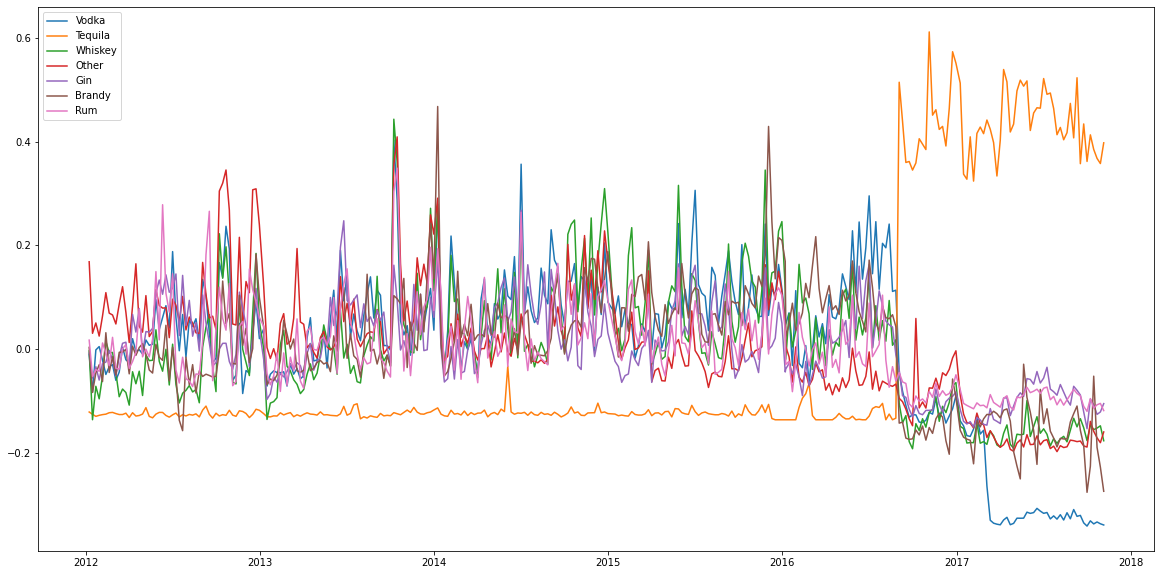

In [ ]:
# plot the normalized sales per item. each item is normalized according to itself, not to the overall
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

for drink in drinks:
  plt.plot(avg_df['ds'], avg_df[drink])
  
plt.legend(drinks)
plt.show()

In [ ]:
# here I am making a list of pd dataframes, each element is a shop. They are in order, from 1 to 1881. 
# EG. to select shop 7 -> prophet_df[7]

prophet_df = []

for i in range(max(data_tot.store_id)):
  prophet_df.append(data_tot[data_tot['store_id'] == i])

#here I am selecting only those shops that are present in the 2017 and have more than 52 weeks of life, 
# otherwise it means that they failed.

df=[]
df = [prophet_df[shop].dropna() for shop in range(len(prophet_df)) if any(prophet_df[shop].ds.dt.year == 2017) and len(prophet_df[shop]) >= 52]
# I have been dropping the nan in the line above

Text(0.5, 0.98, 'On x axis is weeks, and Y axis is n. weeks')

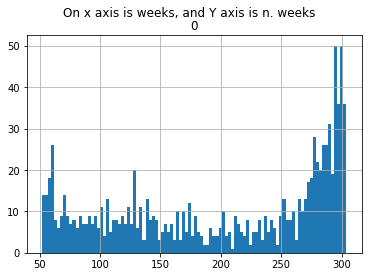

In [ ]:
#here I print the average age of the shops selected, we see that they're equal or higher than the threshold fixed before (min 52 weeks)
ages=[]
for i in df:
  ages.append(i.shape[0])


weeks_per_shop = pd.DataFrame(ages)
hist = weeks_per_shop.hist(bins=100)
plt.suptitle("On x axis is weeks, and Y axis is n. weeks")

# Here I run the Prophet model as released by Facebook.
the dataset I am using has the total sales as y and ds as the date. I predict for the coming year with a weekly interval

In [ ]:
#here I plot the data set used for the prophet analsysis
data_tot.head()

,store_id,ds,y
0,0,2012-01-08,12291.43
1,1,2012-01-08,590.18
2,2,2012-01-08,4860.96
3,7,2012-01-08,75616.51
4,8,2012-01-08,18770.17


In [ ]:
#https://towardsdatascience.com/prophet-in-a-loop-a875516ef2f9 # the website from which I took most of the code in this cell

from tqdm import tqdm # this is just to see how fast it is going

m = Prophet()
fcst_all = pd.DataFrame()  # store all forecasts here
fcst_yhat = pd.DataFrame() 
fcst_trend = pd.DataFrame() # store only future performance  here
itemlist=data_tot.store_id.unique()
shops_considered=[]

for x in tqdm(itemlist):
  temp = data_tot[data_tot.store_id == x] #  here we re considering one shop at the time
  
  #if any(temp.ds==pd.Timestamp("2017-11-05 00:00:00")) and len(temp) >= 50: #too restrictive condition
  if any(temp.ds.dt.year == 2017) and len(temp) >= 50: # maybe some shops closed in 2017 but you never know
    #print('I consider shop ', str(x))
    shops_considered.append(x)
    pass
  else:
    #print('I WILL NOT CONSIDER SHOP ', str(x))
    continue

  d_df = temp.set_index('ds') # I dont really get why I first set the index and the I drop it
  
  d_df = d_df.reset_index().dropna() # I dont really get why I first set the index and the I drop it
  
  d_df['ds'] = pd.date_range(end = '11/5/2017', periods = len(d_df['ds']), freq = 'W') # here I am shifting all the dates to the 5th November. I am a bit cheating

 


  try:
    m = Prophet(seasonality_mode='additive',interval_width=0.95).fit(d_df)
    future = m.make_future_dataframe(periods=52, freq='W')
  except ValueError:
    pass
  fcst = m.predict(future) 
  #plot1 = m.plot(fcst )
  fcst['store_id'] = x
  fcst['amount'] = d_df['y'].reset_index(drop = True)
  fcst['change%'] = (fcst['yhat'].iloc[-52:,] - fcst['yhat'].iloc[-52,]) / fcst['yhat'].iloc[-52,] # here is the normalization. yhat is the predicted blue line

  start_step_yhat = fcst['yhat'].tolist()[-52]
  change_in_percent_yhat = [(i - start_step_yhat) / start_step_yhat for i in fcst['yhat'].tolist()[-52:]]
  
  start_step_trend = fcst['trend'].tolist()[-52]
  change_in_percent_trend = [(i - start_step_trend) / start_step_trend for i in fcst['trend'].tolist()[-52:]]
                                    
  fcst_all = pd.concat((fcst_all, fcst))
  
  column_name = 'shop_' + str(x)
  fcst_yhat[column_name] = change_in_percent_yhat  # fcst['yhat'].iloc[-52:,] are the last 52 lines, meaning the future prediction      
  fcst_trend[column_name] = change_in_percent_trend   # fcst['yhat'].iloc[-52,] is the first prediction, the one to which all is compared


# here I save the outputs

fcst_all.to_csv('gdrive/MyDrive/ING/ProphetFc.csv', index=False)
fcst_yhat.to_csv('gdrive/MyDrive/ING/ProphetFc_yhat.csv', index=False)
fcst_trend.to_csv('gdrive/MyDrive/ING/ProphetFc_trend.csv', index=False)

## Here we see the outputs of Prophet, no analysis is done yet

In [ ]:
# Upload the data from trend and prevision, obtained with the prophet method (the prevision or (hat) is the yearly inclination , from the prophet model)
prfmc_trend = pd.read_csv('gdrive/MyDrive/ING/ProphetFc_trend.csv')
prfmc_yhat = pd.read_csv('gdrive/MyDrive/ING/ProphetFc_yhat.csv')

In [ ]:
# this is to get the list of shops considered without running the prophet. You have it already if you runned the prophet
from tqdm import tqdm
itemlist=data_tot.store_id.unique()
shops_considered=[]
for x in tqdm(itemlist):
  temp = data_tot[data_tot.store_id == x]
  
  #if any(temp.ds==pd.Timestamp("2017-11-05 00:00:00")) and len(temp) >= 50: #too restrictive condition
  if any(temp.ds.dt.year==2017) and len(temp) >= 50: # maybe some shops closed in 2017 but you never know
    #print('I consider shop ', str(x))
    shops_considered.append(x)

100%|██████████| 1711/1711 [00:02<00:00, 660.16it/s]


In [ ]:
# here I am writing the names of the columns for both dataframes
prfmc_trend.columns = [i + str(j) for i, j in zip(['shop_']*len(shops_considered), shops_considered)] # shops_considered are the indexes of the shops selected according to year adn n of weeks
prfmc_yhat.columns = [i + str(j) for i, j in zip(['shop_']*len(shops_considered), shops_considered)]


In [ ]:
print(prfmc_trend.info(), prfmc_yhat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 1058 entries, shop_0 to shop_1710
dtypes: float64(1058)
memory usage: 429.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 1058 entries, shop_0 to shop_1710
dtypes: float64(1058)
memory usage: 429.9 KB
None ------------- None


In [ ]:
# data cleaning from eventual na
prfmc_trend = prfmc_trend.dropna()
prfmc_yhat = prfmc_yhat.dropna()
prfmc_yhat.head()

,shop_0,shop_1,shop_2,shop_7,shop_8,shop_9,shop_12,shop_13,shop_18,shop_21,shop_24,shop_25,shop_26,shop_27,shop_28,shop_29,shop_33,shop_34,shop_37,shop_38,shop_39,shop_40,shop_43,shop_44,shop_45,shop_47,shop_48,shop_49,shop_50,shop_51,shop_52,shop_53,shop_54,shop_55,shop_56,shop_58,shop_59,shop_63,shop_64,shop_65,...,shop_1611,shop_1612,shop_1613,shop_1619,shop_1620,shop_1622,shop_1624,shop_1625,shop_1626,shop_1627,shop_1629,shop_1630,shop_1632,shop_1636,shop_1638,shop_1642,shop_1643,shop_1646,shop_1649,shop_1655,shop_1659,shop_1661,shop_1667,shop_1668,shop_1673,shop_1674,shop_1684,shop_1690,shop_1691,shop_1868,shop_1628,shop_1633,shop_1686,shop_1688,shop_1689,shop_1701,shop_1702,shop_1694,shop_1709,shop_1710
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.112632,-0.050851,-0.018006,0.096752,-0.154712,0.111457,0.011223,-0.029473,-0.011568,0.020076,-0.167084,-0.009220,0.012625,0.474330,0.628883,-0.005420,-0.015511,-0.384941,-0.106386,0.190618,-0.266305,0.581874,-0.086463,0.202953,0.085688,-0.131391,0.172420,-0.000639,0.176609,-0.286316,-0.093024,0.086625,-0.179694,0.579175,0.075549,0.084505,0.140162,-0.096883,0.392021,0.158031,...,-0.004358,-0.015505,-0.020504,-0.005404,-0.008281,-0.002248,-0.004737,0.014174,-0.009299,-0.011633,-0.007219,-0.015227,-0.002467,-0.003073,-0.017774,-0.021895,0.006755,-0.010489,-0.005725,-0.010243,-0.006199,-0.025050,-0.003414,0.012805,0.006265,0.007226,-0.004152,-0.010924,-0.008752,-0.000131,-0.012264,-0.027480,-0.001563,-0.009228,-0.034246,-0.004795,-0.388053,-0.014776,-0.002814,-0.016779
2,-0.078279,-0.098794,0.041952,0.167452,-0.367489,0.131845,0.045287,-0.582364,-0.006103,-0.039963,-0.198312,0.001154,-0.089247,-0.504023,2.253286,-0.091090,-0.161249,-0.438070,-0.086034,0.211603,-0.447532,0.870350,-0.400442,0.323357,0.225715,-0.155389,0.216137,0.084928,0.495043,-0.463999,-0.073049,-0.022951,-0.428565,0.790584,0.254173,0.242477,0.327026,-0.087842,0.504270,0.514980,...,-0.008717,-0.031010,-0.041009,-0.010808,-0.016561,-0.004497,-0.009475,0.028349,-0.018598,-0.023267,-0.014438,-0.030454,-0.004933,-0.006145,-0.035549,-0.043790,0.013511,-0.020977,-0.011449,-0.020486,-0.012398,-0.050101,-0.006829,0.025609,0.012529,0.014451,-0.008303,-0.021848,-0.017504,-0.000261,-0.024528,-0.054960,-0.003126,-0.018455,-0.068492,-0.009589,-0.776107,-0.029551,-0.005628,-0.033557
3,-0.010427,-0.147808,0.101888,0.187246,-0.542973,0.091572,-0.045727,-0.958390,0.018335,-0.124230,-0.097826,-0.025417,-0.234147,-1.848751,3.589757,-0.162010,-0.380208,-0.318824,0.031880,0.104082,-0.465796,0.625934,-0.792117,0.263093,0.276210,-0.109770,0.077399,0.279511,0.649804,-0.478492,0.034162,-0.187047,-0.567066,0.470201,0.533044,0.297874,0.375430,-0.004172,0.236641,0.555309,...,-0.013075,-0.046514,-0.061513,-0.016212,-0.024842,-0.006745,-0.014212,0.042523,-0.027897,-0.034900,-0.021656,-0.045680,-0.007400,-0.009218,-0.053323,-0.065685,0.020266,-0.031466,-0.017174,-0.030728,-0.018597,-0.075151,-0.010243,0.038414,0.018794,0.021677,-0.012455,-0.032773,-0.026256,-0.000392,-0.036792,-0.082441,-0.004689,-0.027683,-0.102737,-0.014384,-1.164160,-0.044327,-0.008442,-0.050336
4,-0.025144,-0.185070,0.112185,0.150109,-0.620211,0.036119,-0.189167,-0.193150,0.047900,-0.150994,0.005628,-0.119209,-0.283508,-1.961994,3.588370,-0.115658,-0.539311,-0.182686,0.054629,0.006439,-0.401630,0.00810

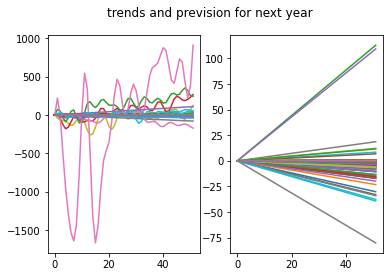

In [ ]:
# plot the trend and the prevision. trend on the left. The prevision or (hat) is the yearly inclination , from the prophet model
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

prfmc_yhat.plot(ax=axes[0], legend= None)
plt.suptitle("trends and prevision for next year")
prfmc_trend.plot(ax=axes[1], legend= None)



#ANALYSIS OF PERFORMANCE

here start the analysis (ANOVA) according to how many competitors or institutions are present in the neighbourhood. The simple idea is to run an ANOVA on the three groups that are being created

In [ ]:
# uploading the dataset of the neighbours
data_dt =  pd.read_csv('gdrive/MyDrive/ING/store_distances_anonymized.csv')
data_dt.head()

,store_id_1,store_id_2,distance
0,0,80,4.472470
1,0,87,1.621428
2,0,140,2.226306
3,0,174,2.904311
4,0,348,3.788029


In [ ]:
# here I eliminate all shops that do not have data in the 2017, or that have less than 52 weeks (too young to get a fund)
# if I had time I 'd make a separate analysis on those wiht less than 52 weeks.

data_dt = data_dt.drop(data_dt[[i not in shops_considered for i in data_dt['store_id_1']]].index)
data_dt = data_dt.drop(data_dt[[i not in shops_considered for i in data_dt['store_id_2']]].index) # this to check that they neighbours are actually in activity
data_dt.head()

,store_id_1,store_id_2,distance
0,0,80,4.472470
1,0,87,1.621428
3,0,174,2.904311
4,0,348,3.788029
6,0,467,2.142012


Text(0.5, 0.98, 'frequency of neighbouring shops')

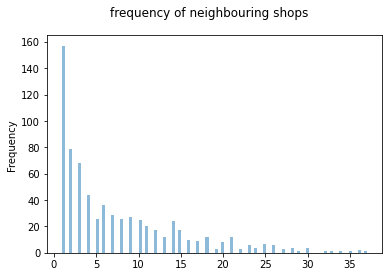

In [ ]:
# data pivot, with on the x axis the number of competitors per shop, and the y axis the frequency
counts_comp = data_dt.pivot_table(index=['store_id_1'], aggfunc='size')
counts_comp.plot.hist(bins=100, alpha=0.5)
plt.suptitle("frequency of neighbouring shops")

In [ ]:
# in this line I report the index of those shops that have 0 shops in the neighbourhood. I will add it in the next cell
shops_0_comp = set(shops_considered).difference(counts_comp.index)

Text(0.5, 0.98, 'frequency of neighbouring shops')

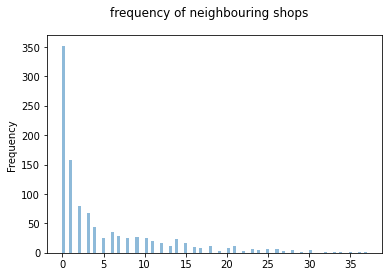

In [ ]:
# I add those shops that have 0 competitors in the neighbourhood
for i in shops_0_comp:
  line = pd.Series([0], index=[i])  
  counts_comp = counts_comp.append(line)

  
counts_comp = counts_comp.sort_index()
counts_comp.plot.hist(bins=100, alpha=0.5)
plt.suptitle("frequency of neighbouring shops")

# you see that the bar of 0 has increased

In [ ]:
# I create the three groups, according to how many competitors are around. 
# less than 2, between 2 and 10 and more than 10. 
# the groups are balanced enough

counts = pd.DataFrame(counts_comp)
counts.columns = ['n_comp']
counts['no_comp'] = counts['n_comp'] < 1
counts['more_than_4'] = counts['n_comp'] >= 5
counts['between'] = (counts['n_comp'] >= 1) & (counts['n_comp'] < 5)
counts.head()

,n_comp,no_comp,more_than_4,between
0,18,False,True,False
1,0,True,False,False
2,34,False,True,False
6,1,False,False,True
7,36,False,True,False


In [ ]:
# here I find the shops for the three different conditions 
columns_no_comp=['shop_'+str(i) for i in counts[counts.no_comp].index.to_list()]
columns_more_than_4=['shop_'+str(i) for i in counts[counts.more_than_4].index.to_list()]
columns_between=['shop_'+str(i) for i in counts[counts.between].index.to_list()]
#prfmc_trend[columns_to_filter]

(-1.0, 0.2)

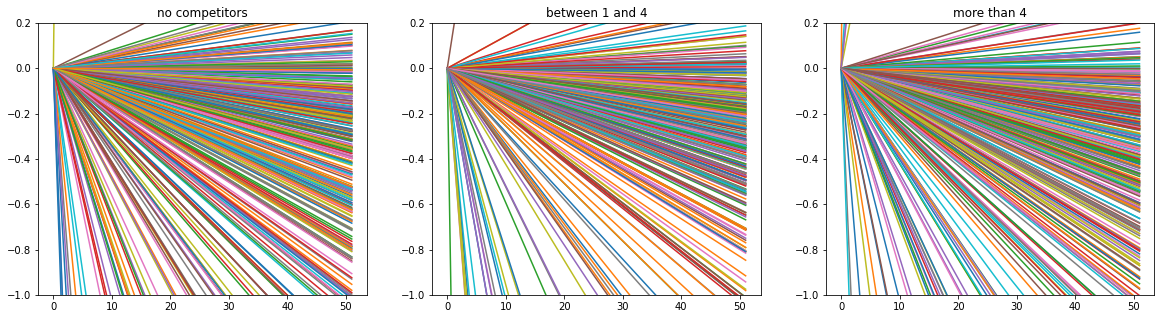

In [ ]:
# data vizualition on the prediction (yearly trend). it has been put between -1 and 1. -1 mean that it loses everything and 1 doubles its gains

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

x_1 = prfmc_trend[columns_no_comp].plot(ax=axes[0], legend=None, title = 'no competitors')
x_1.set_ylim(-1,0.2)
x_2 = prfmc_trend[columns_between].plot(ax=axes[1], legend=None, title = 'between 1 and 4')
x_2.set_ylim(-1,0.2)
x_3 = prfmc_trend[columns_more_than_4].plot(ax=axes[2],legend=None, title = 'more than 4')
x_3.set_ylim(-1,0.2)

In [ ]:
# I apply a linear regression to all the provision to extract the slope. So that I will run some statistics on the slope coefficients
# this second option is easier and more straightforward
import numpy as np
import pandas as pd
from scipy.stats import linregress

slopes = prfmc_trend.apply(lambda x: linregress(prfmc_trend.index, x), result_type='expand').rename(index={0: 'slope', 1: 
                                                                                  'intercept', 2: 'rvalue', 3:
                                                                                  'p-value', 4:'stderr'})
slopes.head()

,shop_0,shop_1,shop_2,shop_7,shop_8,shop_9,shop_12,shop_13,shop_18,shop_21,shop_24,shop_25,shop_26,shop_27,shop_28,shop_29,shop_33,shop_34,shop_37,shop_38,shop_39,shop_40,shop_43,shop_44,shop_45,shop_47,shop_48,shop_49,shop_50,shop_51,shop_52,shop_53,shop_54,shop_55,shop_56,shop_58,shop_59,shop_63,shop_64,shop_65,...,shop_1611,shop_1612,shop_1613,shop_1619,shop_1620,shop_1622,shop_1624,shop_1625,shop_1626,shop_1627,shop_1629,shop_1630,shop_1632,shop_1636,shop_1638,shop_1642,shop_1643,shop_1646,shop_1649,shop_1655,shop_1659,shop_1661,shop_1667,shop_1668,shop_1673,shop_1674,shop_1684,shop_1690,shop_1691,shop_1868,shop_1628,shop_1633,shop_1686,shop_1688,shop_1689,shop_1701,shop_1702,shop_1694,shop_1709,shop_1710
slope,-2.016967e-02,-1.027707e-02,-5.839501e-03,-8.074971e-04,-2.336030e-02,-7.632929e-03,-1.058964e-02,-4.066130e-03,-1.003258e-02,-3.078799e-03,-7.479331e-03,-6.275446e-03,-1.081578e-02,-2.526181e-02,-4.041582e-03,-1.976186e-03,-8.558494e-03,-1.065087e-02,-6.752894e-03,-6.658884e-03,-2.457860e-02,-8.585763e-03,-3.771472e-02,-8.106285e-03,-0.006392,-9.188655e-03,-3.930265e-03,-7.513286e-03,-1.246141e-02,-4.746370e-03,-4.548876e-03,-3.616257e-03,-6.558900e-03,-4.153041e-03,-2.966299e-03,-3.817938e-03,-3.904970e-03,-1.377063e-03,-1.233109e-02,-1.321791e-02,...,-4.358469e-03,-1.550476e-02,-2.050437e-02,-5.404162e-03,-8.280746e-03,-2.248416e-03,-4.737286e-03,1.417435e-02,-9.298878e-03,-1.163337e-02,-0.007219,-1.522676e-02,-2.466608e-03,-3.072597e-03,-1.777431e-02,-2.189488e-02,6.755314e-03,-0.010489,-0.005725,-1.024276e-02,-6.199091e-03,-2.505040e-02,-3.414420e-03,1.280454e-02,6.264604e-03,7.225663e-03,-4.151551e-03,-1.092423e-02,-8.752096e-03,-1.306628e-04,-0.012264,-2.748019e-02,-1.563096e-03,-9.227662e-03,-3.424580e-02,-4.794656e-03,-3.880533e-01,-1.477556e-02,-2.814082e-03,-0.016779
intercept,-3.330669e-16,-1.110223e-16,-2.775558e-17,0.000000e+00,-1.110223e-16,2.775558e-16,1.110223e-16,0.000000e+00,-2.220446e-16,5.551115e-17,5.551115e-17,-1.387779e-16,-1.110223e-16,-2.220446e-16,-1.387779e-16,-1.040834e-16,-1.665335e-16,-2.775558e-16,2.775558e-16,1.387779e-16,9.992007e-16,3.330669e-16,-1.110223e-16,-2.775558e-17,0.000000,1.665335e-16,-6.938894e-17,-2.220446e-16,5.551115e-17,-1.526557e-16,9.714451e-17,8.326673e-17,-1.110223e-16,1.249001e-16,1.387779e-17,6.938894e-17,-9.714451e-17,-2.775558e-17,4.996004e-16,-2.220446e-16,...,-1.387779e-17,5.551115e-17,1.110223e-16,8.326673e-17,-2.775558e-17,-4.163336e-17,-4.163336e-17,5.551115e-17,-5.551115e-17,-5.551115e-17,0.000000,1.110223e-16,-2.775558e-17,5.551115e-17,-2.220446e-16,3.330669e-16,2.775558e-17,0.000000,0.000000,2.220446e-16,1.110223e-16,-2.220446e-16,5.551115e-17,-1.110223e-16,-1.665335e-16,-2.775558e-17,1.387779e-17,3.330669e-16,-2.775558e-17,-3.686287e-17,0.000000,-1.110223e-16,1.040834e-16,5.551115e-17,-4.440892e-16,1.110223e-16,-5.329071e-15,5.551115e-17,6.938894e-17,0.000000
rvalue,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000
p-value,0.

In [ ]:
# I create a new dataframe with the slopes coeff and the three conditions of competition

slope_col = slopes.loc['slope'].to_list()
df = pd.concat([counts['no_comp'], counts['between'], counts['more_than_4']], 1)

df['slopes'] = slope_col
df.head()

,no_comp,between,more_than_4,slopes
0,False,False,True,-0.020170
1,True,False,False,-0.010277
2,False,False,True,-0.005840
6,False,True,False,-0.000807
7,False,False,True,-0.023360


Text(0.5, 1.0, 'slopes of the trends')

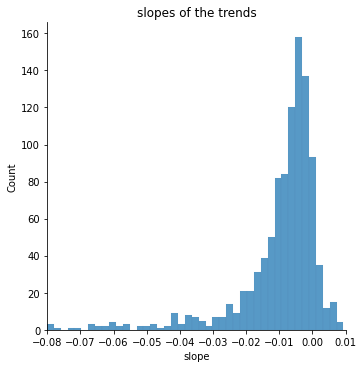

In [ ]:
# the overall situation, of the coefficients of the slopes
import seaborn as sns

sns.displot(slopes.loc['slope'])
plt.xlim(-0.08, 0.01)
plt.title('slopes of the trends')

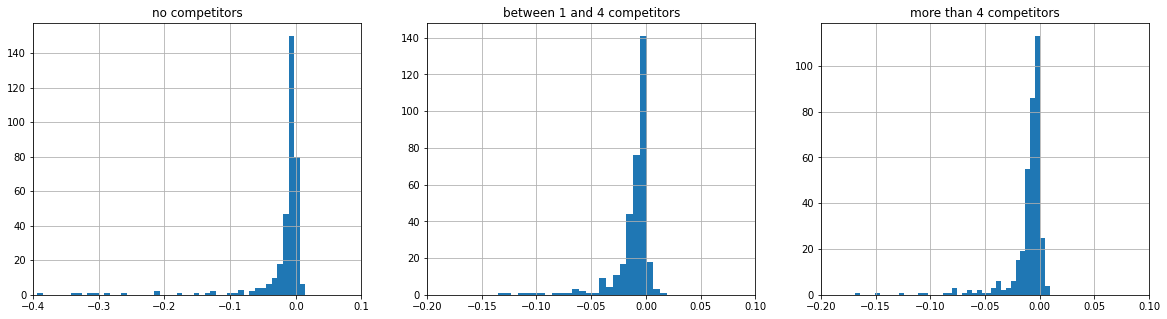

In [ ]:
# plot the coefficients according to the competitors conditions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

x_1 = df[df['no_comp']==True]['slopes'].hist(ax=axes[0],legend=None, bins=350)
x_1.set_xlim(-0.4,0.1)
x_1.title.set_text('no competitors')

x_2 = df[df['between']==True]['slopes'].hist(ax=axes[1],legend=None, bins=600)
x_2.set_xlim(-0.2,0.1)
x_2.title.set_text('between 1 and 4 competitors')

x_3 = df[df['more_than_4']==True]['slopes'].hist(ax=axes[2],legend=None, bins=100)
x_3.set_xlim(-0.2,0.1)
x_3.title.set_text('more than 4 competitors')

## it really looks like that the number of competitors does not have an effect on the future performance

In [ ]:
# I run an ANOVA to see whether the competitors condition affect the performance for the next year (the  coeff of the slopes)
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df[df['no_comp']==True]['slopes'], df[df['between']==True]['slopes'], df[df['more_than_4'] == True]['slopes'])
print(fvalue, pvalue)
# 0.5181189345214321 0.5957914146059158

# we see no significant effect, check pvalue

0.5181189345214321 0.5957914146059158


In [ ]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# prepare the data frame as required by R

df_less = pd.DataFrame(df[df['no_comp']==True]['slopes'])
df_less['treatment']='less'

df_between = pd.DataFrame(df[df['between']==True]['slopes'])
df_between['treatment']='between'

df_more = pd.DataFrame(df[df['more_than_4']==True]['slopes'])
df_more['treatment']='more'

df_melt = pd.concat([df_less, df_between,df_more])
df_melt.tail()

,slopes,treatment
1403,-0.007303,more
1423,-0.014447,more
1431,-0.125381,more
1478,-0.020263,more
1506,-0.008663,more


In [ ]:
# Ordinary Least Squares (OLS) model

model = ols('slopes ~ C(treatment)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table



,sum_sq,df,F,PR(>F)
C(treatment),0.015843,2.0,0.518119,0.595791
Residual,16.129431,1055.0,NaN,NaN
